# This script demonstrates how to build a conditional variational autoencoder with vae_tools

In [1]:
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
import matplotlib
import matplotlib.pyplot as plt

python version:  3.5.2
keras version: 2.2.4-tf
tensorflow version: 2.0.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
No GPUs available


In [2]:
# Get the MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

Store model to filename: tmp/myVAE.png and tmp/myVAE.svg
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_conditional (InputLayer)  [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 794)          0           input[0][0]                      
                                                                 input_conditional[0][0]          
__________________________________________________________________________________________________
enc_0 (Dense)                   (None

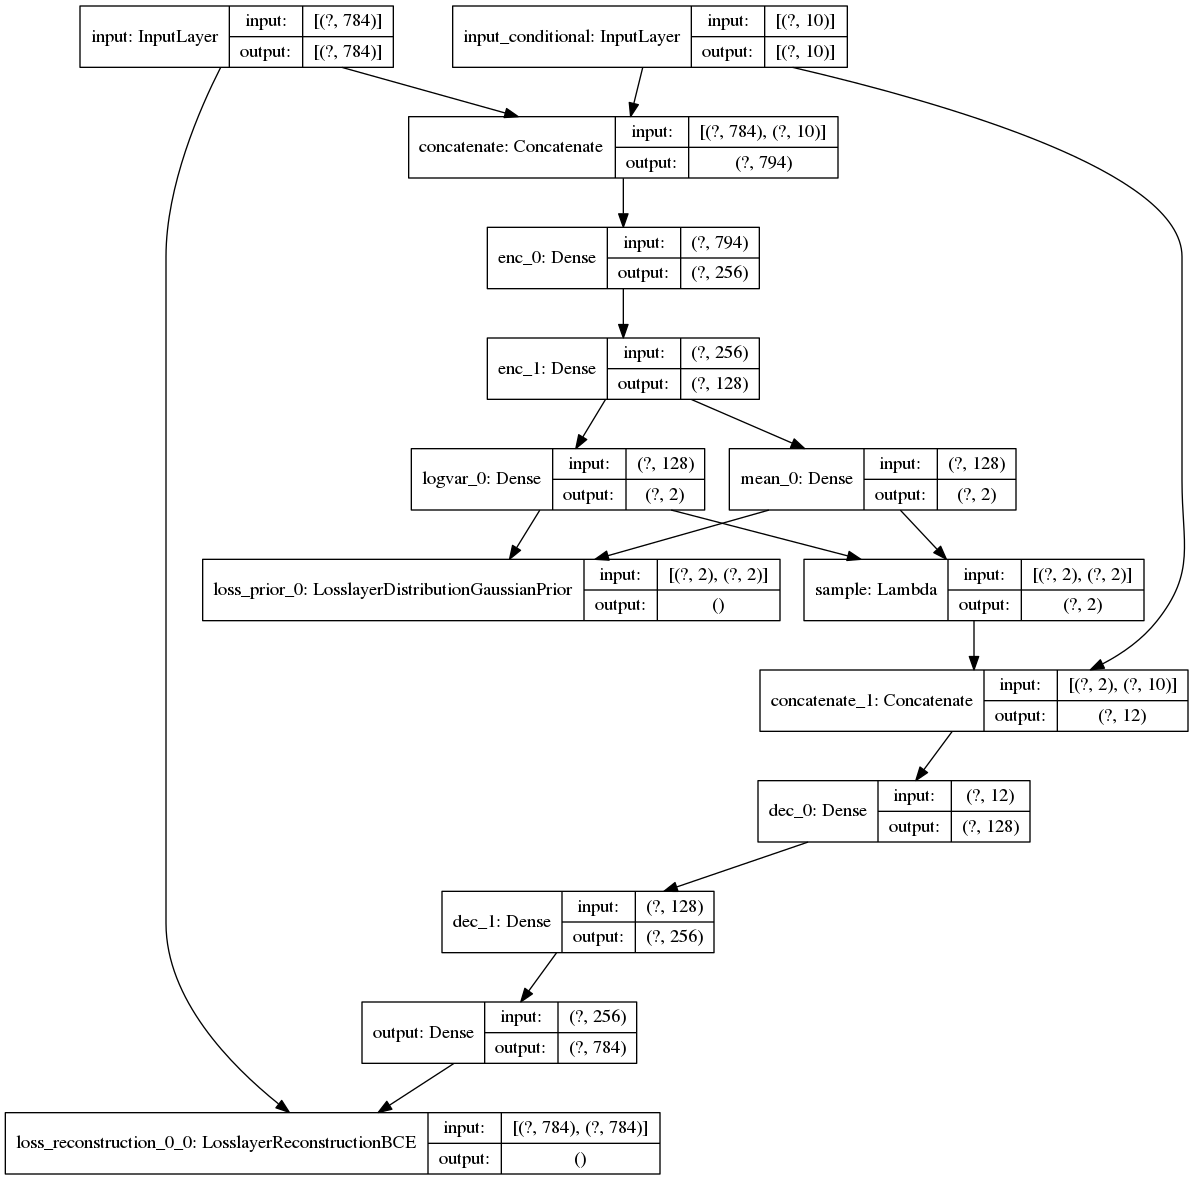

In [3]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
batch_size = 1024
original_dim = img_rows * img_cols * img_chns
intermediate_dim = 256
epochs = 5
z_dim = 2
beta = 1.

# Define the function which return the conditional layer 
conditional_input = Input(shape=(10,), name="input_conditional")
def conditional_layer(layer):
    return concat([layer, conditional_input])

encoder = [[
    Input(shape=(original_dim,), name="input"),                       # Input layer
    conditional_layer,                                                # Concat input with conditional 
    Dense(intermediate_dim, activation='relu', name="enc_0"),         # First encoder layer
    Dense(int(intermediate_dim/2), activation='relu', name="enc_1")   # Second encoder layer
]]

decoder = [[
    conditional_layer,                                                # Concat latent with conditional 
    Dense(int(intermediate_dim/2), activation='relu', name="dec_0"),  # First decoder layer
    Dense(intermediate_dim, activation='relu', name="dec_1"),         # Second decoder layer
    Dense(original_dim, activation='sigmoid', name="output")          # Output layer
]]

vae_obj = MmVae(z_dim, encoder, decoder, [original_dim], beta, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name='Vae')

vae = vae_obj.get_model(extra_inputs = [conditional_input])
vae.compile(optimizer='rmsprop', loss=None)
vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

In [4]:
# Train
vae.fit([x_train, y_train_cat],
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, y_test_cat], None),
            verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 140us/sample - loss: 242.1919 - val_loss: 197.6836

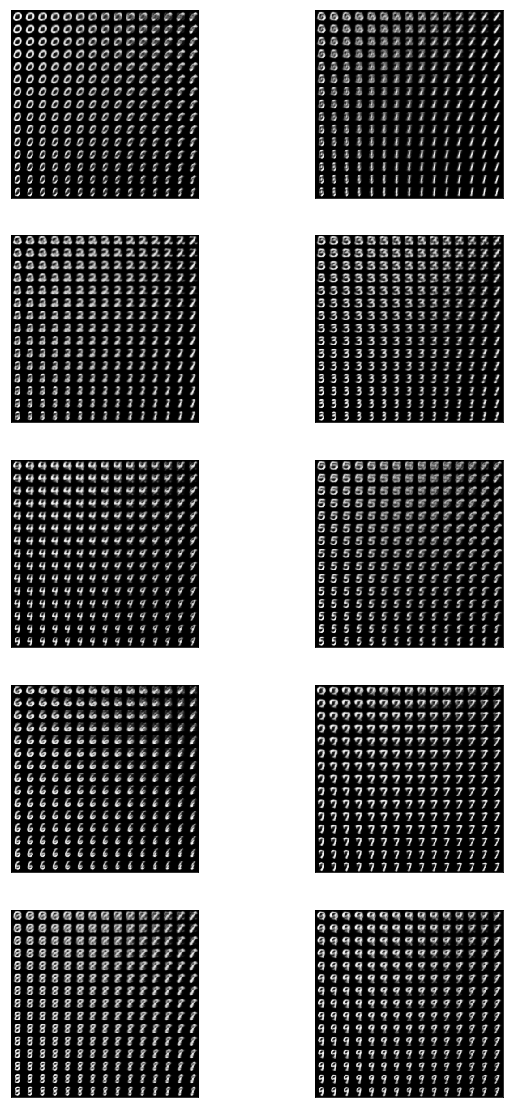

In [5]:
# build a digit generator that can sample from the learned distribution
generator = vae_obj.get_decoder(extra_inputs = [conditional_input])
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 20))
_ax = ax.flatten()
# display a 2D manifold of each digit
for label in np.arange(0, 10):
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            y_sample_cat = np.zeros((1, 10))
            y_sample_cat[0, label] = 1
            x_decoded = generator.predict([z_sample, y_sample_cat])
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    # _ax[label].figure(figsize=(10, 10))
    _ax[label].imshow(figure, cmap='Greys_r')
    _ax[label].set_xticks([])
    _ax[label].set_yticks([])
plt.show()

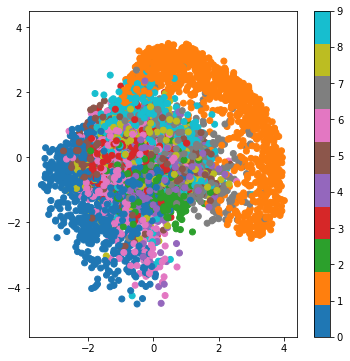

In [6]:
# build a model to project inputs on the latent space
encoder_input = [encoder[0][0]]
encoder_model = vae_obj.get_encoder_mean(encoder_input, extra_inputs = [conditional_input])
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder_model.predict([x_test, y_test_cat], batch_size=batch_size)
f = plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.axis("equal")
plt.show()